In [9]:
%load_ext autoreload
%autoreload 2
from mod_3_project import *
import warnings
warnings.filterwarnings('ignore')

<h1><center>An analysis of grade distributions at UW-Madison</center></h1>
<h2><center>by Max Schulte and Nicholas Schafer</center></h2>

<img src="memorialterrace.jpg">

### Incoming freshman at UW-Madison?

### Looking to avoid the ill-effects of fluctuating grade distributions? 

### You may be in luck. 

### Here, we analyze the influence of several factors on grades distributed at UW-Madison including time of day and instructor.

## Introduction to the data set

Downloaded from [uploaded to Kaggle](https://www.kaggle.com/Madgrades/uw-madison-courses). 

Provided by the folks at [madgrades](https://madgrades.com/) 

Here, we are asking some questions that are not addressed on the site.

Vocabulary: 
- a *course* can be taught over multiple years and by different instructors 
- a *course offering* refers to a specific time that a course was taught

## Introduction to grade distributions

The letter grades that a student can receive at UW-Madison (and the corresponding grade points awarded) are:
- A (4.0)
- AB (3.5)
- B (3.0)
- BC (2.5)
- C (2.0)
- D (1.0)
- F (0.0)

There are no "CD" or "DF" grades.

## Introduction to grade distributions

$$ PDF(Grade)=\frac{\text{# of each particular grade given}}{\text{total # of grades given}} $$

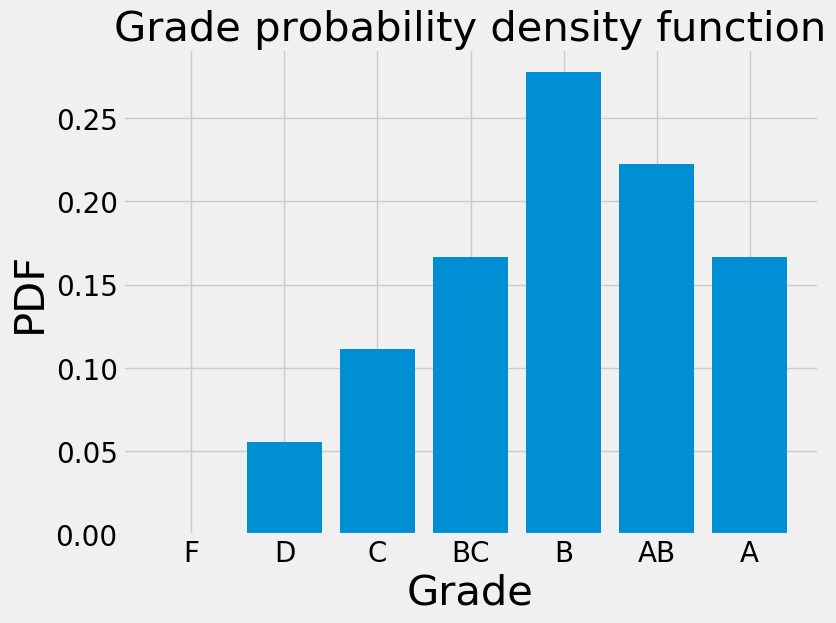

In [10]:
plot_grade_distribution([0, 1, 2, 3, 5, 4, 3], barplot=True, lineplot=False, distribution_type='pdf')

To overlay multiple distributions, we can represent a PDF with a line:

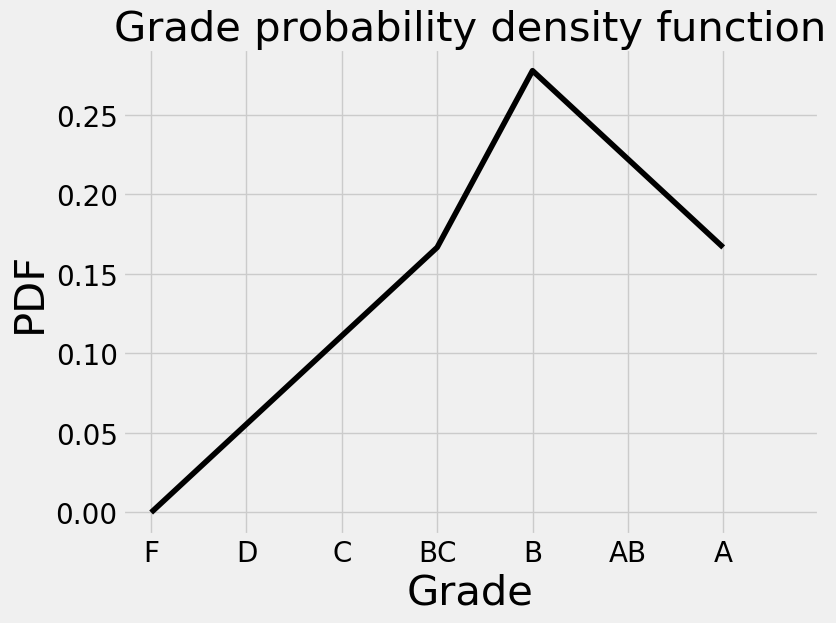

In [11]:
plot_grade_distribution([0, 1, 2, 3, 5, 4, 3], barplot=False, lineplot=True, distribution_type='pdf')

Our comparisons will be performed on the CDFs instead of the PDFs.

$$ CDF(Grade)=\sum_{Grades \leq Grade} PDF(Grade) $$

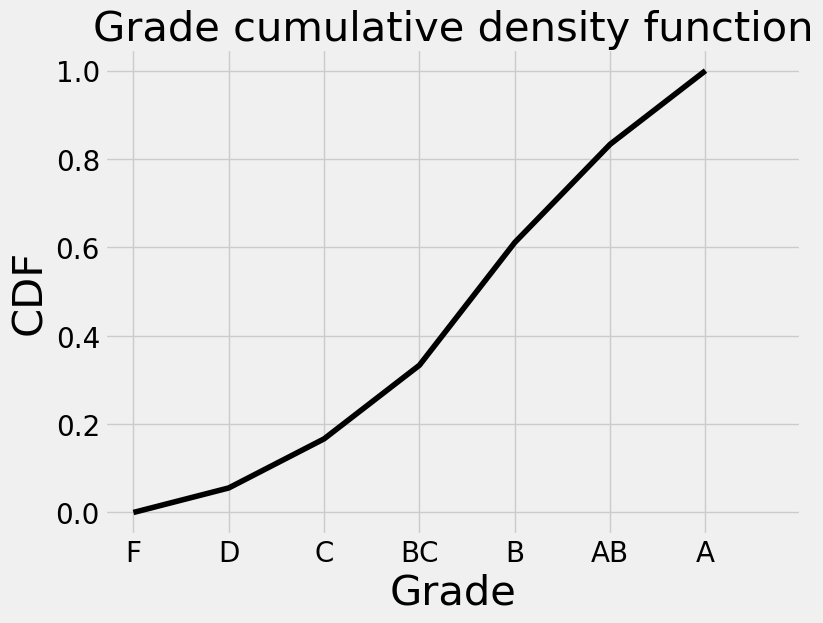

In [12]:
plot_grade_distribution([0, 1, 2, 3, 5, 4, 3], barplot=False, lineplot=True, distribution_type='cdf')

## Do different instructors distribute grades differently when teaching the same courses?

- Differences between grades given by different instructors will certainly exist

- Can we attribute these differences to instructors?

### Importing Data

### Data query and cleaning

Conveniently, Kaggle provides a sqlite database containing the Madgrades data. Our friend Alan Hong kindly built this schema for the database using [dbdiagram.io](https://dbdiagram.io/home).

In [ ]:
Conclusion: 

<img src="alan-schema.png" width=60%>

In [11]:
conn = sqlite3.connect('database.sqlite3')
c = conn.cursor()

In [12]:
df = sql_to_pandas_df("""SELECT co.course_uuid as course_uuid,
                    c.name as course_name,
                    c.number as course_number,
                    g.course_offering_uuid as course_offering_uuid,
                    s.section_type as section_type,
                    co.term_code as course_offering_term_code,
                    t.instructor_id as instructor_id,
                    i.name as instructor_name,
                    su.name as subject_name,
                    su.code as subject_code,
                    g.a_count as a_count,
                    g.ab_count as ab_count,
                    g.b_count as b_count,
                    g.bc_count as bc_count,
                    g.c_count as c_count,
                    g.d_count as d_count,
                    g.f_count as f_count
                     FROM grade_distributions g
                     JOIN course_offerings co ON g.course_offering_uuid = co.uuid
                     JOIN sections s ON co.uuid = s.course_offering_uuid
                     JOIN teachings t ON t.section_uuid = s.uuid
                     JOIN courses c ON c.uuid = co.course_uuid
                     JOIN instructors i ON i.id = t.instructor_id
                     JOIN subject_memberships sm ON sm.course_offering_uuid = co.uuid
                     JOIN subjects su ON su.code = sm.subject_code
                     """, c)

In [13]:
len(df)

2206765

Initially, there are more than 2 million rows in our resulting dataframe. Since we are interested in courses that issue letter grades, we can filter out any rows for which the sum of all of the letter grade counts is zero. Although not strictly necessary, this can be made slightly easier by first creating a new column with the total number of letter grades. Also, since we are starting to mathematically manipulate the data, we may as well cast all of the letter grade counts to integers.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2206765 entries, 0 to 2206764
Data columns (total 17 columns):
course_uuid                  object
course_name                  object
course_number                object
course_offering_uuid         object
section_type                 object
course_offering_term_code    object
instructor_id                object
instructor_name              object
subject_name                 object
subject_code                 object
a_count                      object
ab_count                     object
b_count                      object
bc_count                     object
c_count                      object
d_count                      object
f_count                      object
dtypes: object(17)
memory usage: 286.2+ MB


The grade counts are currently strings. We want integers.

In [15]:
convert_grades_to_ints(df)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2206765 entries, 0 to 2206764
Data columns (total 17 columns):
course_uuid                  object
course_name                  object
course_number                object
course_offering_uuid         object
section_type                 object
course_offering_term_code    object
instructor_id                object
instructor_name              object
subject_name                 object
subject_code                 object
a_count                      int64
ab_count                     int64
b_count                      int64
bc_count                     int64
c_count                      int64
d_count                      int64
f_count                      int64
dtypes: int64(7), object(10)
memory usage: 286.2+ MB


Find classes that have some letter grades.

In [17]:
add_total_grades(df)

In [18]:
df = filter_no_grades(df)

In [19]:
len(df)

860334

Select lecture sections.

In [20]:
df["section_type"].unique()

array(['FLD', 'LAB', 'LEC', 'IND', 'DIS', 'SEM'], dtype=object)

In [21]:
df = get_only_lecture_section(df)

In [22]:
df["section_type"].unique()

array(['LEC'], dtype=object)

In [23]:
len(df)

402289

We're now down to a little over 400,000 rows. It turns out that not all of these rows are unique course offerings because, when we joined our tables initially, for those courses with multiple simultaneous instructors, multiple rows were created. This could create confusion later when we compare different instructors, because when multiple instructors simultaneously teach the same course, they, by definition, end up issuing the same grade distribution. We attempted to solve this problem by making combined ```instructor_id``` and ```instructor_name``` identifiers.

In [24]:
groups_list = list(df.groupby("course_offering_uuid"))

In [25]:
groups_list[10][1].head()

,course_uuid,course_name,course_number,course_offering_uuid,section_type,course_offering_term_code,instructor_id,instructor_name,subject_name,subject_code,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,total_grades
1020711,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,704430,JOHANNA ALLEX,Law,528,2,0,6,0,0,0,0,8
1020712,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,704430,JOHANNA ALLEX,Law,528,2,0,1,0,0,0,0,3
1020713,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,704430,JOHANNA ALLEX,Law,528,2,0,1,0,0,0,0,3
1020714,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,765400,ANDREW SEABORG,Law,528,2,0,6,0,0,0,0,8
1020715,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,765400,ANDREW SEABORG,Law,528,2,0,1,0,0,0,0,3


In [26]:
example_multiple_instructor_course_offering_uuid = "000d5c53-ea02-39b6-94c5-bf22e5d9a7be"

In [27]:
make_combined_instructor_ids_for_team_teachers(df)

In [28]:
df[df["course_offering_uuid"] == example_multiple_instructor_course_offering_uuid].head()

,course_uuid,course_name,course_number,course_offering_uuid,section_type,course_offering_term_code,instructor_id,instructor_name,subject_name,subject_code,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,total_grades
1020711,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,4542841-704430-765400-776515,ANDREW SEABORG-IRIS CHRISTENSON-JOHANNA ALLEX-...,Law,528,2,0,6,0,0,0,0,8
1020712,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,4542841-704430-765400-776515,ANDREW SEABORG-IRIS CHRISTENSON-JOHANNA ALLEX-...,Law,528,2,0,1,0,0,0,0,3
1020713,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,4542841-704430-765400-776515,ANDREW SEABORG-IRIS CHRISTENSON-JOHANNA ALLEX-...,Law,528,2,0,1,0,0,0,0,3
1020714,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,4542841-704430-765400-776515,ANDREW SEABORG-IRIS CHRISTENSON-JOHANNA ALLEX-...,Law,528,2,0,6,0,0,0,0,8
1020715,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,4542841-704430-765400-776515,ANDREW SEABORG-IRIS CHRISTENSON-JOHANNA ALLEX-...,Law,528,2,0,1,0,0,0,0,3


Having preserved the information about all of the instructors that taught for a particular course offering, we will now eliminate any duplicate course offerings from the database.

In [29]:
df = filter_duplicate_course_offering_uuids(df)

In [30]:
df[df["course_offering_uuid"] == example_multiple_instructor_course_offering_uuid].head()

,course_uuid,course_name,course_number,course_offering_uuid,section_type,course_offering_term_code,instructor_id,instructor_name,subject_name,subject_code,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,total_grades
1020711,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,4542841-704430-765400-776515,ANDREW SEABORG-IRIS CHRISTENSON-JOHANNA ALLEX-...,Law,528,2,0,6,0,0,0,0,8


In [31]:
len(df)

42527

Select courses that have at least two instructors.

In [32]:
df = filter_only_one_instructor(df)

In [33]:
len(df)

35078

It turns out that there are still more than 35,000 course offerings that we can analyze, so let's get to it!

### Methodology for comparing grades distributed by different instructors

- Group course offerings for each course

- Group course offerings by instructor

- Combine all grades given by a particular instructor

- Compute PDF and CDF

Let's have a look at an example course, "Topics in Luso-Brazilian Literature".

In [98]:
df[df["course_uuid"] == "00a17f67-ed74-3d86-9876-9a677ef991e4"]

,course_uuid,course_name,course_number,course_offering_uuid,section_type,course_offering_term_code,instructor_id,instructor_name,subject_name,subject_code,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,total_grades
2061178,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,2266ef80-9f5c-3249-b032-9a774a1fd6ff,LEC,1092,2600133,ELLEN SAPEGA,Portuguese (Spanish and Portuguese),782,4,3,0,0,0,0,0,7
2061180,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,5781ca9c-7f01-393f-b577-b74062357397,LEC,1082,1056851,KATHRYN SANCHEZ,Portuguese (Spanish and Portuguese),782,5,1,1,0,0,0,1,8
2061182,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,eef6ab6b-f093-3182-80b7-279201f156e1,LEC,1102,2600699,SEVERINO ALBUQUERQUE,Portuguese (Spanish and Portuguese),782,6,3,0,0,0,0,1,10
2061184,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,a43c7552-cc0d-3a26-9abd-d8b3471b73d3,LEC,1104,2600133,ELLEN SAPEGA,Portuguese (Spanish and Portuguese),782,4,4,0,0,0,0,0,8
2061185,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,2ddb62fc-18ce-3b97-85ad-21eec3d1ca85,LEC,1162,2600104,LUIS MADUREIRA,Portuguese (Spanish and Portuguese),782,5,1,0,0,0,0,0,6
2061187,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,f2e0d0f4-88c8-3104-95df-14a844833c44,LEC,1074,2600699,SEVERINO ALBUQUERQUE,Portuguese (Spanish and Portuguese),782,4,3,0,0,0,0,0,7


- Course was taught by 4 instructors

- What do the instructor CDFs look like?

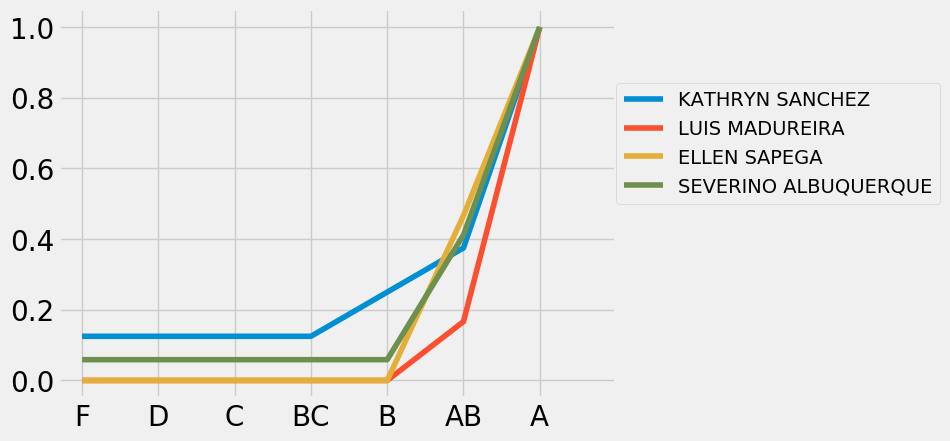

In [108]:
plot_instructor_cdfs(df, "00a17f67-ed74-3d86-9876-9a677ef991e4")

- Some differences exist; are they significant?

- Apply variant of KS test
    - Plot all CDFs
    - Compute maximum difference between any two CDFs
    - Randomly permute instructor labels
    - Find how often random permutations lead to a maximum difference that is *as large as or greater than* the maximum difference in the original data 

Original data

In [115]:
brazilian_df = df[df["course_uuid"] == "00a17f67-ed74-3d86-9876-9a677ef991e4"]
brazilian_df

,course_uuid,course_name,course_number,course_offering_uuid,section_type,course_offering_term_code,instructor_id,instructor_name,subject_name,subject_code,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,total_grades
2061178,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,2266ef80-9f5c-3249-b032-9a774a1fd6ff,LEC,1092,2600133,ELLEN SAPEGA,Portuguese (Spanish and Portuguese),782,4,3,0,0,0,0,0,7
2061180,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,5781ca9c-7f01-393f-b577-b74062357397,LEC,1082,1056851,KATHRYN SANCHEZ,Portuguese (Spanish and Portuguese),782,5,1,1,0,0,0,1,8
2061182,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,eef6ab6b-f093-3182-80b7-279201f156e1,LEC,1102,2600699,SEVERINO ALBUQUERQUE,Portuguese (Spanish and Portuguese),782,6,3,0,0,0,0,1,10
2061184,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,a43c7552-cc0d-3a26-9abd-d8b3471b73d3,LEC,1104,2600133,ELLEN SAPEGA,Portuguese (Spanish and Portuguese),782,4,4,0,0,0,0,0,8
2061185,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,2ddb62fc-18ce-3b97-85ad-21eec3d1ca85,LEC,1162,2600104,LUIS MADUREIRA,Portuguese (Spanish and Portuguese),782,5,1,0,0,0,0,0,6
2061187,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,f2e0d0f4-88c8-3104-95df-14a844833c44,LEC,1074,2600699,SEVERINO ALBUQUERQUE,Portuguese (Spanish and Portuguese),782,4,3,0,0,0,0,0,7


In [116]:
permute_column_in_dataframe(brazilian_df, ["instructor_id", "instructor_name"])

In [117]:
brazilian_df

,course_uuid,course_name,course_number,course_offering_uuid,section_type,course_offering_term_code,instructor_id,instructor_name,subject_name,subject_code,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,total_grades
2061178,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,2266ef80-9f5c-3249-b032-9a774a1fd6ff,LEC,1092,2600104,LUIS MADUREIRA,Portuguese (Spanish and Portuguese),782,4,3,0,0,0,0,0,7
2061180,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,5781ca9c-7f01-393f-b577-b74062357397,LEC,1082,2600133,ELLEN SAPEGA,Portuguese (Spanish and Portuguese),782,5,1,1,0,0,0,1,8
2061182,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,eef6ab6b-f093-3182-80b7-279201f156e1,LEC,1102,2600699,SEVERINO ALBUQUERQUE,Portuguese (Spanish and Portuguese),782,6,3,0,0,0,0,1,10
2061184,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,a43c7552-cc0d-3a26-9abd-d8b3471b73d3,LEC,1104,2600699,SEVERINO ALBUQUERQUE,Portuguese (Spanish and Portuguese),782,4,4,0,0,0,0,0,8
2061185,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,2ddb62fc-18ce-3b97-85ad-21eec3d1ca85,LEC,1162,2600133,ELLEN SAPEGA,Portuguese (Spanish and Portuguese),782,5,1,0,0,0,0,0,6
2061187,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,f2e0d0f4-88c8-3104-95df-14a844833c44,LEC,1074,1056851,KATHRYN SANCHEZ,Portuguese (Spanish and Portuguese),782,4,3,0,0,0,0,0,7


Recompute CDFs with randomly permuted instructor labels

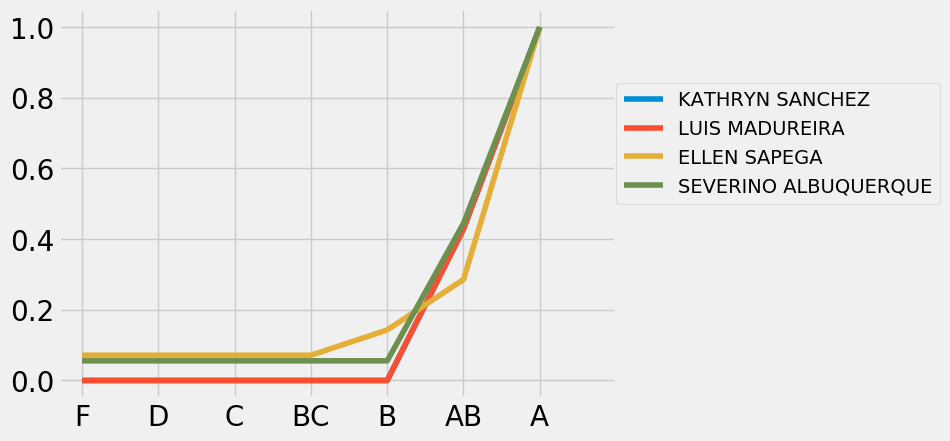

In [120]:
plot_instructor_cdfs(brazilian_df, "00a17f67-ed74-3d86-9876-9a677ef991e4")

Plot actual data in colors, random permutations in translucent gray

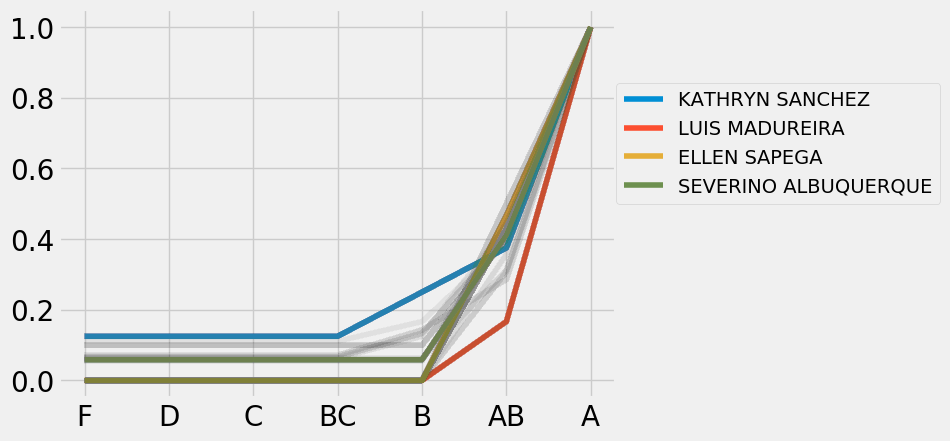

In [125]:
plot_instructor_cdfs(df, "00a17f67-ed74-3d86-9876-9a677ef991e4", 
                     npermutations=100, 
                     plot_all_permuted_cdfs=True, 
                     alpha=0.01)

Plot the distribution of maximum differences obtained when randomly permuting data, compare to real maximum difference

0.18


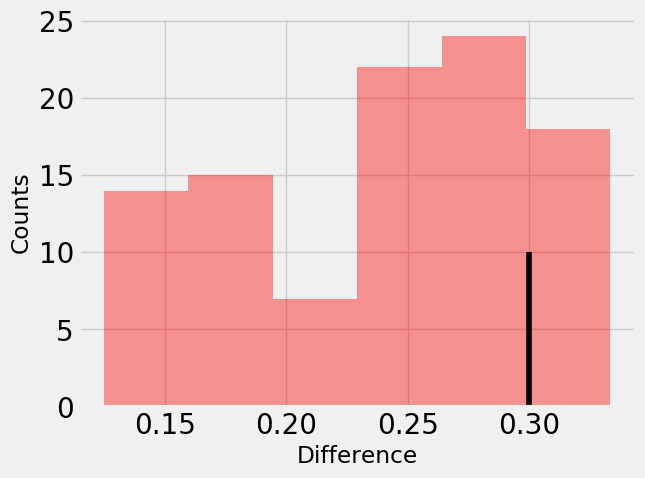

In [39]:
plot_instructor_cdfs(df, "00a17f67-ed74-3d86-9876-9a677ef991e4", 
                     npermutations=100, 
                     plot_all_permuted_cdfs=False,
                     plot_permutation_distribution=True,
                     alpha=0.01,
                     plot_original_cdfs=False)

- 18/100 permutations have an equal or larger maximum difference
- Our "pvalue" is 0.18
- Null hypothesis: "All instructors distribute grades in the same way"
- Alternative hypothesis: "Some instructors distribute grades differently"
- Our test is weak evidence against the null hypothesis.

- Repeated this test for the approximately 5,000 available courses in the database

In [ ]:
# results = compare_instructor_grade_distributions_by_permutation(df, 
#                                                                     npermutations=100, 
#                                                                     load_existing_pickle=False, 
#                                                                     print_progress=True)

In [3]:
results = pickle.load(open("all_pvalues_100.pkl", 'rb'))

### Do some subjects have a larger fraction of classes where grades are distributed differently by different instructors than others?

- Compute mean pvalue per subject
- Compute confidence intervals for these means using bootstrapping

In [28]:
pvalue_by_subject_dict = get_pvalues_by_subject(df, results)

A low mean pvalue: subjects with courses that are graded differently by different instructors.

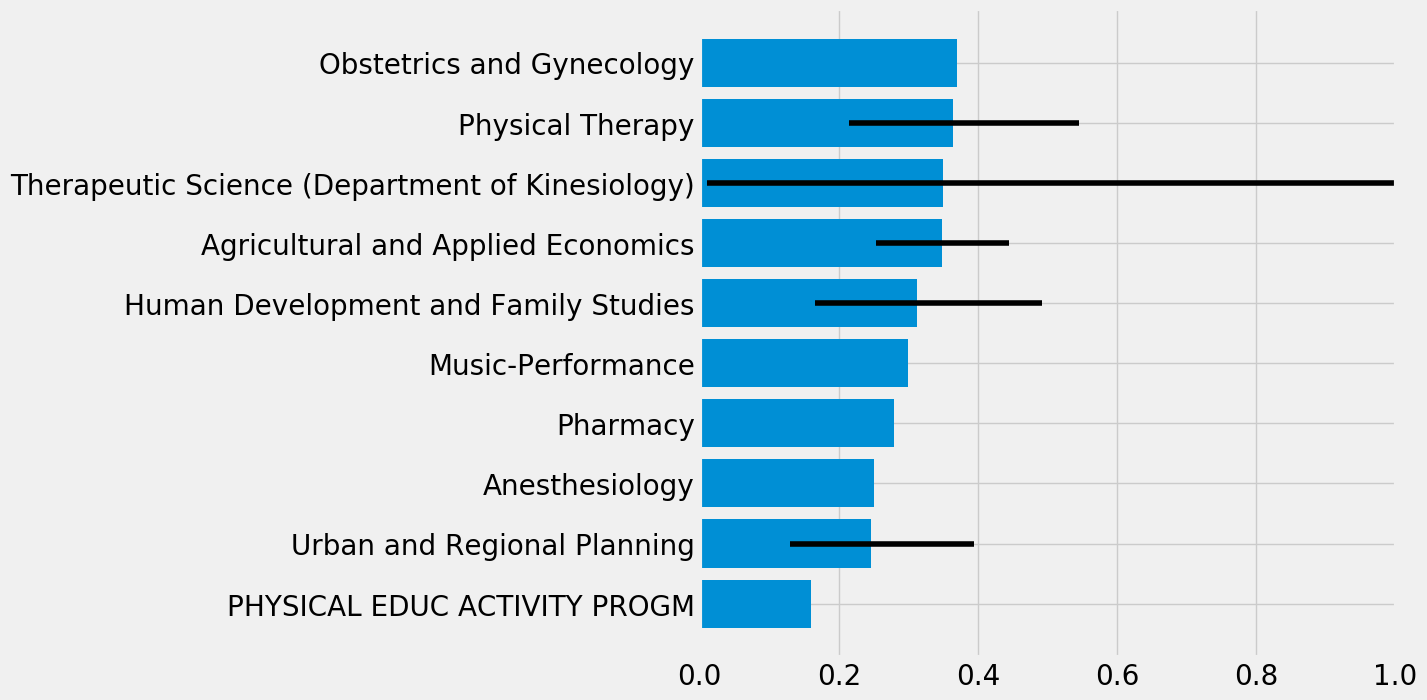

In [82]:
plot_pvalues_by_subject_with_confidence_intervals(pvalue_by_subject_dict, num_to_plot=10)

Apparently physical education grades are fairly subjective. Therapeutic Science has a lower mean pvalue, but also has very wide confidence intervals, which means that it is perhaps unfair to group it in with the rest of the subjects on this list.

In [85]:
pvalue_by_subject_dict["Therapeutic Science (Department of Kinesiology)"]

[0.01, 0.04, 1.0]

As we can see, we only have 3 data points and the values vary quite a bit. More data is needed before we can make any confident conclusions.

A high mean pvalue: subjects with courses that are graded the same by different instructors.

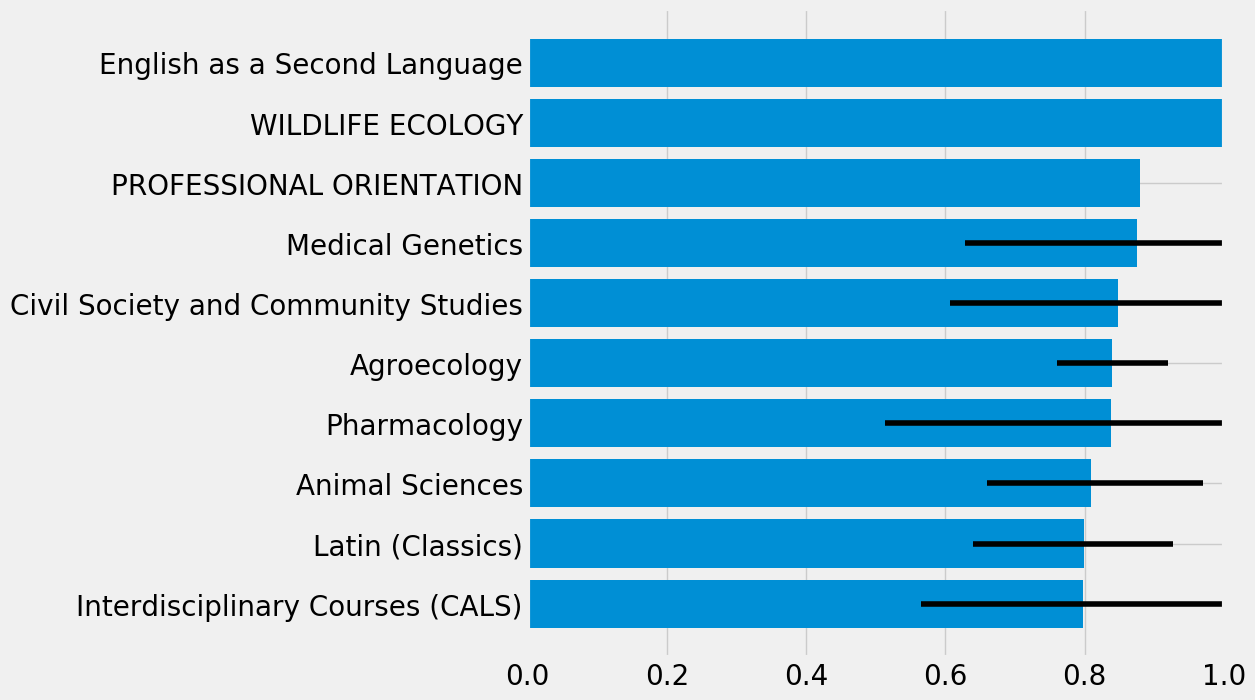

In [83]:
plot_pvalues_by_subject_with_confidence_intervals(pvalue_by_subject_dict, num_to_plot=-10)

## Are grades distributed differently depending upon the time of day?

In [13]:
from sql_helper import *
import sys
# connect to db if possible 
conn, err = con_sql("database.sqlite3")
if err is not None:
    print(err)
    sys.exit()
c = conn.cursor()

In [14]:
df = sql_frame("grade_distributions", conn)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193262 entries, 0 to 193261
Data columns (total 18 columns):
course_offering_uuid    193262 non-null object
section_number          193262 non-null object
n_count                 193262 non-null object
c_count                 193262 non-null object
f_count                 193262 non-null object
cr_count                193262 non-null object
p_count                 193262 non-null object
nw_count                193262 non-null object
other_count             193262 non-null object
bc_count                193262 non-null object
u_count                 193262 non-null object
d_count                 193262 non-null object
ab_count                193262 non-null object
a_count                 193262 non-null object
s_count                 193262 non-null object
i_count                 193262 non-null object
b_count                 193262 non-null object
nr_count                193262 non-null object
dtypes: object(18)
memory usage: 26.5+ MB


Upon importing the grade distribution data, it is easy to see that there is a data that will not be used. What is of interest is the grade count for each letter grade as well as the start time. These will all be filtered later but it is important to keep in mind what is needed for the analysis.

The section table is also needed in order to access the schedule data through the section's schedule id so it is needed as an intermediary merge step.

In [15]:
sections_df = sql_frame("sections", conn)
df = pd.merge(df, sections_df, how="right", on=["course_offering_uuid"])
del sections_df

The column name to merge on, "uuid", is not the same in both tables so it must be changed in the schedules table to match the grade distributions table's "schedule_uuid"

In [16]:
schedules_df = sql_frame("schedules", conn)
schedules_df.columns = [
    "schedule_uuid" if i == "uuid" else i for i in schedules_df.columns
]
df = pd.merge(df, schedules_df, how="outer", on=["schedule_uuid"])
del schedules_df

After everything has been merged and the schedules are now linked to the grade distribution, it is now time to keep only items relevant to the analysis

In [17]:
important_grades = [
    "f_count",
    "d_count",
    "c_count",
    "bc_count",
    "b_count",
    "ab_count",
    "a_count",
]

# course_offering_uuid is needed for a later join
df = df[[*important_grades, "start_time", "course_offering_uuid"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2135901 entries, 0 to 2135900
Data columns (total 9 columns):
f_count                 object
d_count                 object
c_count                 object
bc_count                object
b_count                 object
ab_count                object
a_count                 object
start_time              object
course_offering_uuid    object
dtypes: object(9)
memory usage: 163.0+ MB


### Cleaning Data

Now that all of the data is successfully merged it is time to start looking into how to get the data into the correct format to be processed.  To start with the start time is of string time instead of a time.  Ideally the start time should be a float64 value between 0 and 24 hours.  There are also nan values and -1 placeholders which should be removed from the analysis.

In [18]:
pd.unique(df["start_time"])

array(['-1', '530', '660', '800', '725', '865', '595', '930', '870',
       '1040', '995', '1050', '960', '935', '720', '1140', '945', '1170',
       '1110', '1215', '780', '570', '480', '1080', '465', '840', '1020',
       '810', '1125', '1060', '540', '630', '990', '900', '1055', '985',
       '1025', '795', '1005', '505', '1065', '460', '600', '750', '390',
       '1095', '825', '495', '655', '1145', '1190', '735', '775', '615',
       '1155', '975', '575', '1030', '645', '820', '1115', '1015', '1200',
       '1035', '1185', '535', '1010', '915', '980', '560', '1045', '885',
       '905', '510', '785', '722', '580', '860', '875', '790', '805',
       '740', '525', '890', '435', '920', '940', '515', '555', '850',
       '745', '760', '1100', '585', '955', '665', '925', '855', '705',
       '710', '770', '965', '485', '565', '675', '690', '765', '610',
       '1000', '730', '880', '1160', '950', '640', '450', '830', '590',
       '620', '670', '680', '1260', '550', '895', '970', '420'

In [19]:
# clean_non_time is faster way of getting rid of non numerics
def clean_non_time(x):
    if type(x) is not str:
        return None
    result = int(x)
    if result < 0:
        return None
    return result

df["start_time"] = df["start_time"].apply(clean_non_time)
df = df.dropna()

Since the start time is in minutes it would be more human readable to convert to hours

In [20]:
df["start_time"] = df["start_time"].apply(
    lambda x: int(x) / 60
)
df = df.dropna()
sorted(pd.unique(df["start_time"]))

[0.5,
 1.1666666666666667,
 2.5,
 5.5,
 6.0,
 6.5,
 7.0,
 7.25,
 7.333333333333333,
 7.5,
 7.583333333333333,
 7.666666666666667,
 7.75,
 7.833333333333333,
 7.916666666666667,
 8.0,
 8.083333333333334,
 8.166666666666666,
 8.25,
 8.333333333333334,
 8.416666666666666,
 8.5,
 8.583333333333334,
 8.666666666666666,
 8.75,
 8.833333333333334,
 8.916666666666666,
 9.0,
 9.083333333333334,
 9.166666666666666,
 9.25,
 9.333333333333334,
 9.416666666666666,
 9.5,
 9.583333333333334,
 9.666666666666666,
 9.75,
 9.833333333333334,
 9.916666666666666,
 10.0,
 10.083333333333334,
 10.166666666666666,
 10.25,
 10.333333333333334,
 10.416666666666666,
 10.5,
 10.583333333333334,
 10.666666666666666,
 10.75,
 10.833333333333334,
 10.916666666666666,
 11.0,
 11.083333333333334,
 11.166666666666666,
 11.25,
 11.333333333333334,
 11.416666666666666,
 11.5,
 11.583333333333334,
 11.666666666666666,
 11.75,
 11.833333333333334,
 11.916666666666666,
 12.0,
 12.033333333333333,
 12.083333333333334,
 12.16

Since there are some unreasonable class times it would be reasonable to remove data before 6 AM

In [21]:
df = df.loc[df["start_time"] > 6]
sorted(pd.unique(df["start_time"]))

[6.5,
 7.0,
 7.25,
 7.333333333333333,
 7.5,
 7.583333333333333,
 7.666666666666667,
 7.75,
 7.833333333333333,
 7.916666666666667,
 8.0,
 8.083333333333334,
 8.166666666666666,
 8.25,
 8.333333333333334,
 8.416666666666666,
 8.5,
 8.583333333333334,
 8.666666666666666,
 8.75,
 8.833333333333334,
 8.916666666666666,
 9.0,
 9.083333333333334,
 9.166666666666666,
 9.25,
 9.333333333333334,
 9.416666666666666,
 9.5,
 9.583333333333334,
 9.666666666666666,
 9.75,
 9.833333333333334,
 9.916666666666666,
 10.0,
 10.083333333333334,
 10.166666666666666,
 10.25,
 10.333333333333334,
 10.416666666666666,
 10.5,
 10.583333333333334,
 10.666666666666666,
 10.75,
 10.833333333333334,
 10.916666666666666,
 11.0,
 11.083333333333334,
 11.166666666666666,
 11.25,
 11.333333333333334,
 11.416666666666666,
 11.5,
 11.583333333333334,
 11.666666666666666,
 11.75,
 11.833333333333334,
 11.916666666666666,
 12.0,
 12.033333333333333,
 12.083333333333334,
 12.166666666666666,
 12.25,
 12.333333333333334,
 

Something that also must be done is convert the grade counts to numberic types.  It is also important to consider classes where there are no letter grades, these can also be dropped.

In [22]:
df[important_grades] = df[important_grades].apply(lambda x: pd.to_numeric(x))
df = df.dropna()

In [23]:
df = df.loc[
    (df["c_count"] > 0)
    | (df["f_count"] > 0)
    | (df["bc_count"] > 0)
    | (df["d_count"] > 0)
    | (df["ab_count"] > 0)
    | (df["a_count"] > 0)
]

### Data Transformation

It is much easier for the for humans to wrap their head around a GPA instead of a grade count to it would be best to take steps to calculate this value for each class.  First a total must be computed for each of the grades.  From their a ratio of each grade count to the total of the grades.  The GPA can then be calculated by taking the dot product of the grade ratios with the GPA scale of the grades

In [24]:
grades = df[important_grades].copy()
df["total"] = grades.sum(axis=1)
important_grades_ratios = list(map(lambda x: x + "_ratio", important_grades))
df[important_grades_ratios] = grades[important_grades].apply(lambda x: x / df["total"])

In [25]:
gpa_scale = np.array([0, 1, 2, 2.5, 3, 3.5, 4], dtype="float32")
df["gpa"] = df[important_grades_ratios].apply(lambda x: np.dot(x, gpa_scale), axis=1)

Since there are many different start times it would be helpful to see the start times by which hour of the day that the class starts in

In [26]:
df["hour_within"] = df["start_time"].apply(lambda x: x // 1)

In [27]:
df.head()

,f_count,d_count,c_count,bc_count,b_count,ab_count,a_count,start_time,course_offering_uuid,total,f_count_ratio,d_count_ratio,c_count_ratio,bc_count_ratio,b_count_ratio,ab_count_ratio,a_count_ratio,gpa,hour_within
1268407,0,0,0,0,0,0,46,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,46,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,4.000000,8.0
1268408,0,0,0,0,0,0,41,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,41,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,4.000000,8.0
1268409,0,0,0,0,1,5,13,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,19,0.0,0.0,0.0,0.0,0.052632,0.263158,0.684211,3.815789,8.0
1268410,0,0,0,0,2,6,11,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,19,0.0,0.0,0.0,0.0,0.105263,0.315789,0.578947,3.736842,8.0
1268411,0,0,0,0,0,2,23,8.833333,cb14977e-d147-3110-8bf0-83c363730609,25,0.0,0.0,0.0,0.0,0.000000,0.080000,0.920000,3.960000,8.0


### Gouping Data

Now that the data contains GPA information and which hour the class falls withing, the next step to the analysis would be to group by the hour that the class starts within for comparison between each hour.

In [28]:
# group
gpa_within_hour = df[["gpa", "hour_within"]].groupby("hour_within") 

Visualizing the amount of classes that fall within a group it can be intuited that some groups with smaller sizes should be dropped entirely

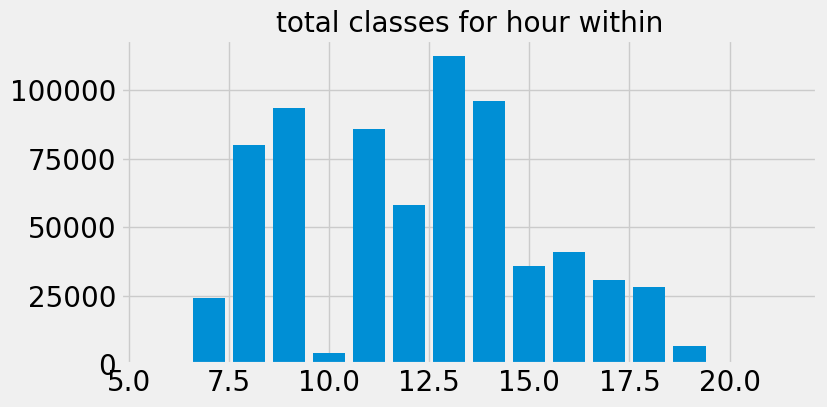

In [29]:
plt.figure(figsize=(8,4 ))
lens = []
for i in gpa_within_hour:
    lens.append(len(i[1]))
plt.bar(list(gpa_within_hour.groups.keys()), lens)
plt.title("total classes for hour within")
plt.show()

there are some time groups that do not have enough data comparatively so they will be rejected

In [30]:
gpa_within_hour = gpa_within_hour.filter(lambda x: len(x) > 5000)
# regroup
gpa_within_hour = gpa_within_hour[["gpa", "hour_within"]].groupby("hour_within") 

### Figures and Observations

##### Distribution of All Grades over Time for a Given Start Time observations
* most times have a significant amount of outliers on the low side of the GPA's for each hour
* GPA's are skewed towards higher GPA's as shown by the short right wisker and long left whiskers
* mean GPA's show the most variance towards the beginning and the end of the day
* times during the middle of the day show the most outliers

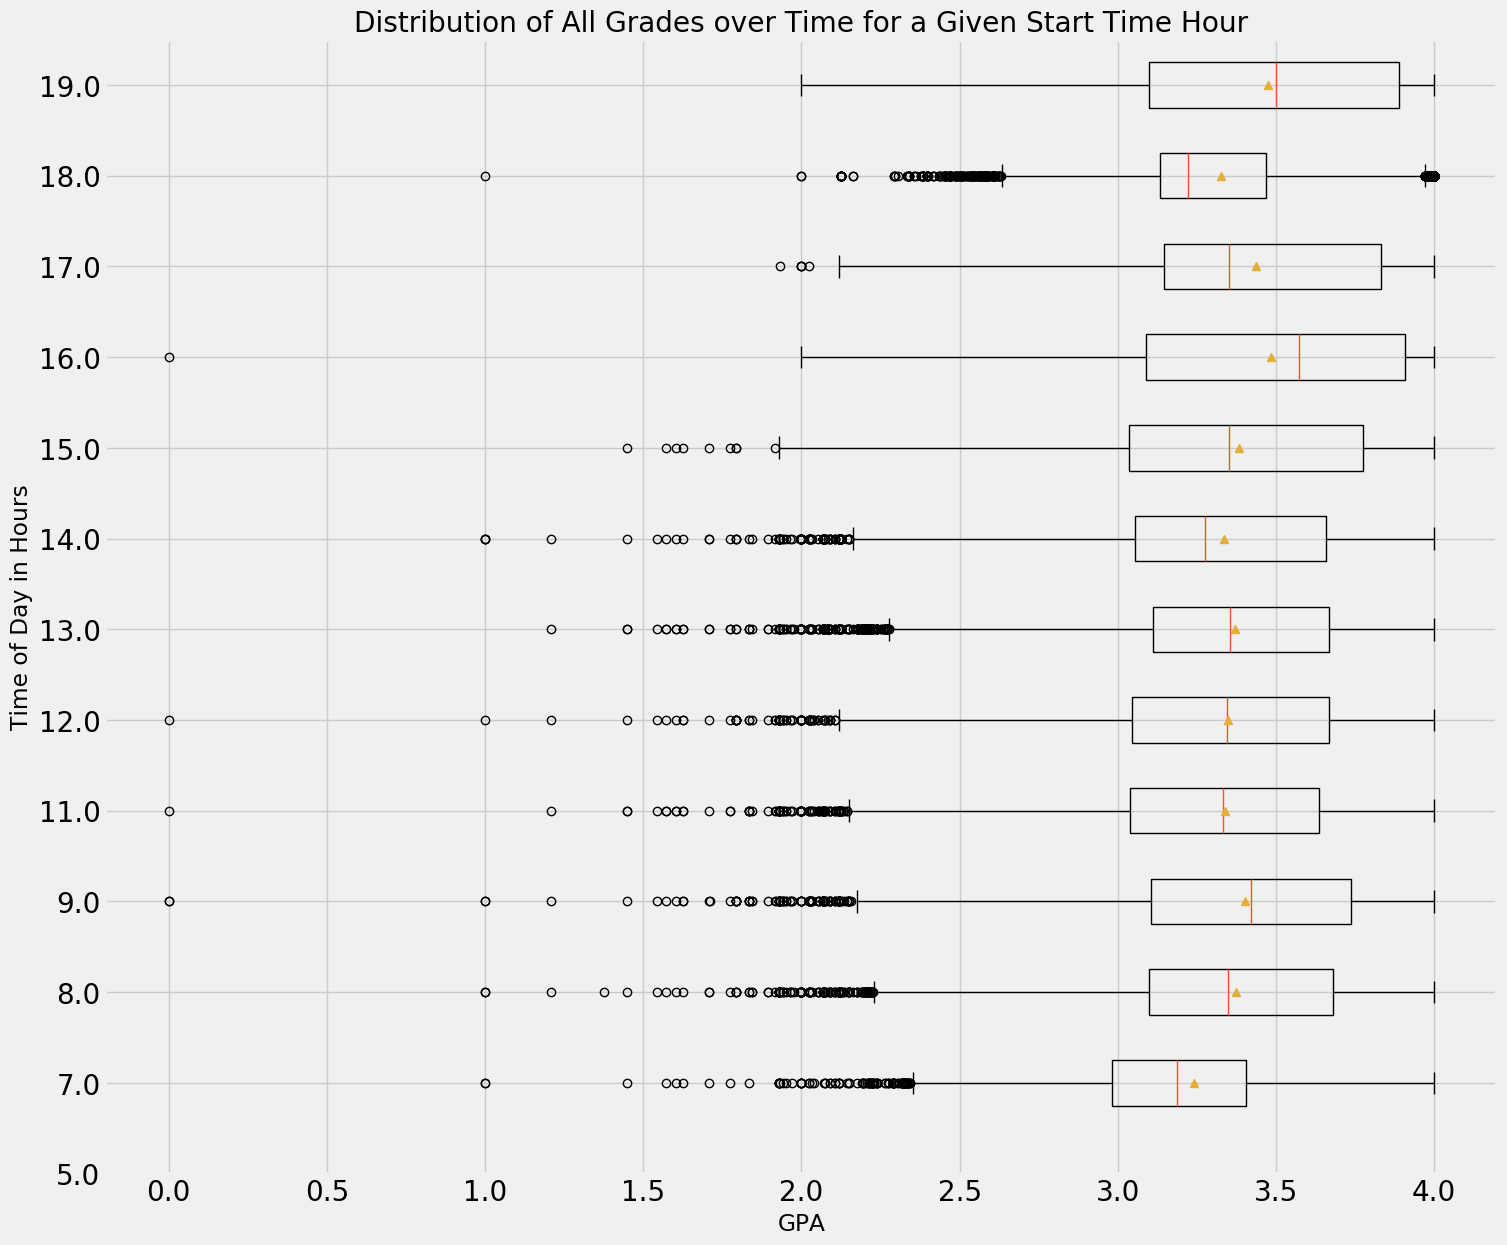

In [31]:
plt.figure(figsize=(16,14))
hours = [5.0]
boxes=[]
for i, hour_gpas in enumerate(gpa_within_hour):
    hours.append(hour_gpas[0])
    boxes.append(hour_gpas[1]["gpa"])
plt.title("Distribution of All Grades over Time for a Given Start Time Hour")
plt.ylabel("Time of Day in Hours")
plt.xlabel("GPA")
plt.boxplot(boxes, vert=0, showmeans=True)
plt.yticks(range(len(hours)), hours)
plt.show()
plt.close()

### Resampling Analysis

To gain some perspective of the observed variance, multiple random samples with replacement can be taken to illustrate the difference between the observation and similar random data.  Doing this 100 samples were taken from the sample population with replacement and then grouped by the hour that they fall within.

In [32]:
gpa_within_hour_mean = gpa_within_hour.apply(lambda x: x.mean())
gpa_within_hour_samples_means = []
for i in range(100):
    gwhsm = gpa_within_hour.obj.sample(len(gpa_within_hour.obj), replace=True)
#     print(len(gwhsm.loc[gwhsm["hour_within"] == 8.0]))
#     plt.hist(gwhsm.loc[gwhsm["hour_within"] == 8.0]["gpa"])
#     break
    gwhsm = gwhsm.groupby("hour_within").apply(lambda x: x.mean())
    gpa_within_hour_samples_means.append(gwhsm)

Plotting this we can see that there is very little variation between our observations and our chances of observing an average grade unexpectedly.  Also we can see that during there is little variation in the grades between 8 AM and 3 PM.  This makes sense considering that the majority of classes take place at these times.

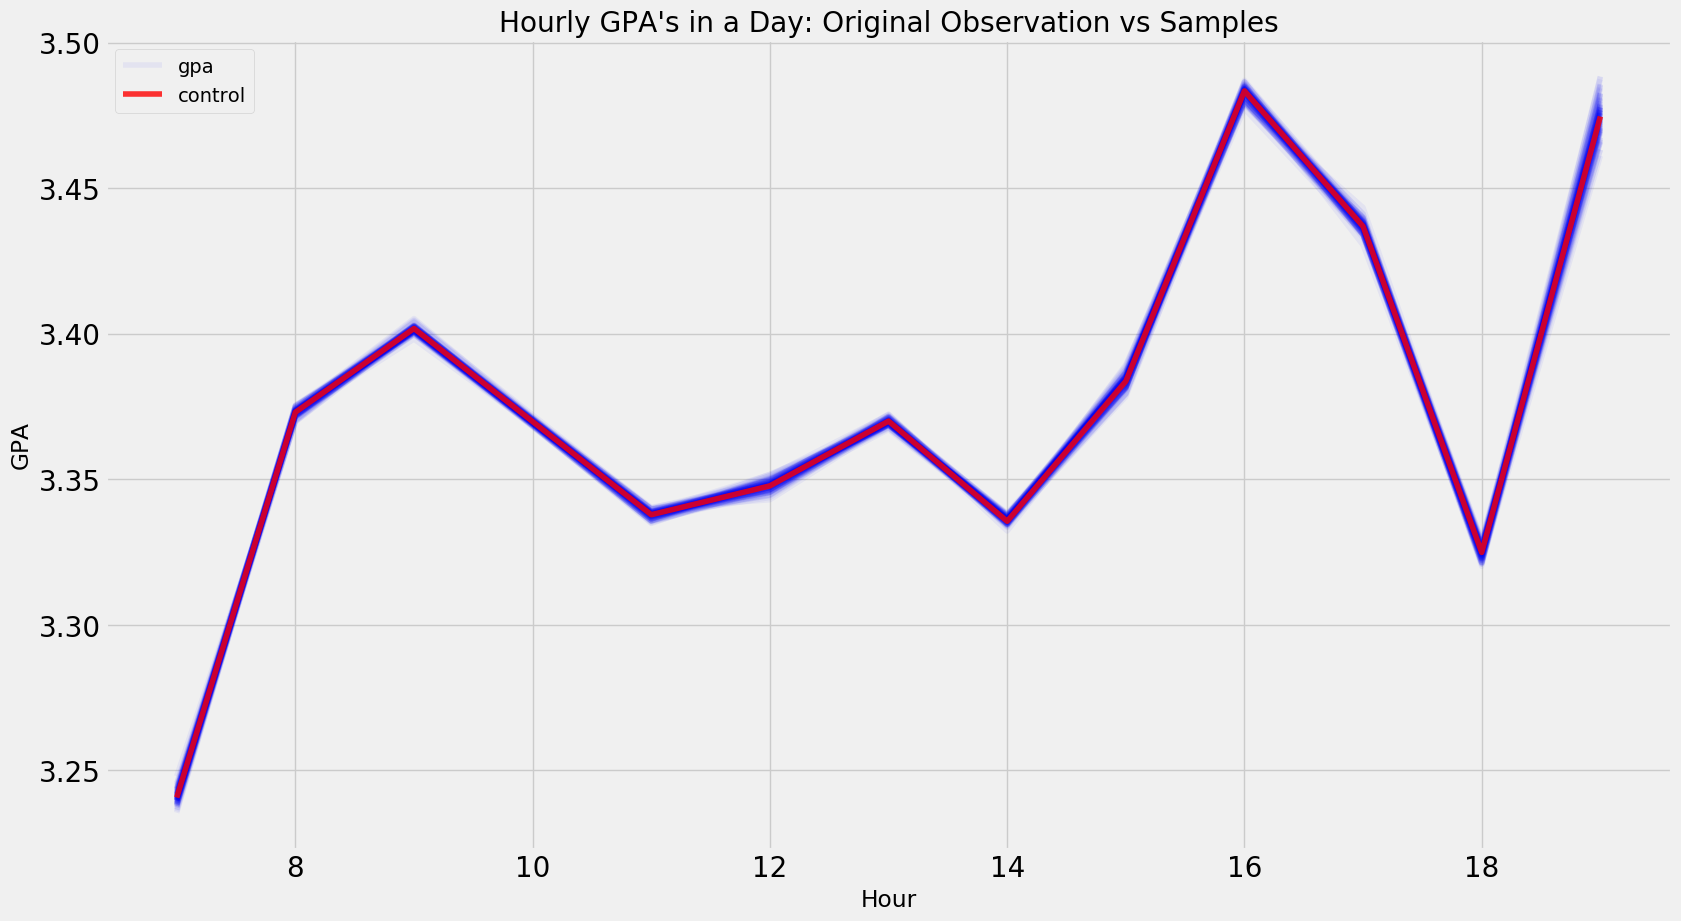

In [33]:
plt.figure(figsize=(18,10))
a = .05
for i, gwhsm in enumerate(gpa_within_hour_samples_means):
    if i == 0:
        plt.plot(gwhsm["gpa"], alpha=a, color="blue")
        continue
    plt.plot(gwhsm["gpa"], alpha=a, color="blue", label="")

plt.xlabel("Hour")
plt.ylabel("GPA")
plt.plot(gpa_within_hour_mean["gpa"], alpha=0.8, label="control", color="red")
plt.title("Hourly GPA's in a Day: Original Observation vs Samples")
plt.legend(loc="upper left")
plt.show()

#### Conclusion: Does the Time of Day Affect the Grade Distribution of a Course?
In short it can be shown that 

## Grouped By Term Analysis

First read in data about the course offerings by term.  There is no mapping of a term to a specific date however the terms are squential and can be treated as if they are their own measure of time

In [34]:
course_offerings_df = sql_frame("course_offerings", conn)
course_offerings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81453 entries, 0 to 81452
Data columns (total 4 columns):
uuid           81453 non-null object
course_uuid    81453 non-null object
term_code      81453 non-null object
name           81453 non-null object
dtypes: object(4)
memory usage: 2.5+ MB


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 695766 entries, 1268407 to 2080599
Data columns (total 19 columns):
f_count                 695766 non-null int64
d_count                 695766 non-null int64
c_count                 695766 non-null int64
bc_count                695766 non-null int64
b_count                 695766 non-null int64
ab_count                695766 non-null int64
a_count                 695766 non-null int64
start_time              695766 non-null float64
course_offering_uuid    695766 non-null object
total                   695766 non-null int64
f_count_ratio           695766 non-null float64
d_count_ratio           695766 non-null float64
c_count_ratio           695766 non-null float64
bc_count_ratio          695766 non-null float64
b_count_ratio           695766 non-null float64
ab_count_ratio          695766 non-null float64
a_count_ratio           695766 non-null float64
gpa                     695766 non-null float64
hour_within             695766 non-

In [ ]:
The course offering uuid needs to be renamed in order to merge with the original distribution of grades

In [36]:
course_offerings_df.columns = list(
    map(
        lambda x:  "course_offering_uuid" if x == "uuid" else x, course_offerings_df.columns
    )
)

In [37]:
grades_to_term_df = pd.merge(course_offerings_df, df, how="right",on=["course_offering_uuid"])

As before, the grades can now be grouped by term code much in the same way they were grouped by start time.

In [38]:
terms_gdf = grades_to_term_df.groupby("term_code")

Plot the amount of classes in each term we expect to see fairly similiar figures for each term

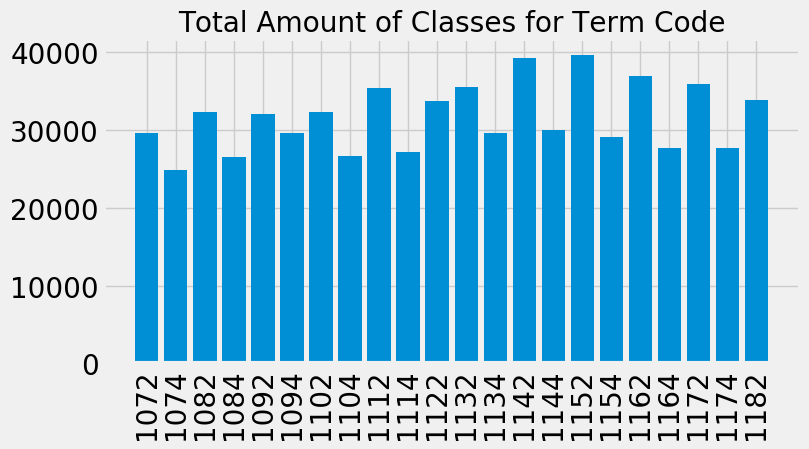

In [39]:
plt.figure(figsize=(8,4))
lens = []
for i in terms_gdf:
    lens.append(len(i[1]))
plt.xticks(rotation=90)
plt.title("Total Amount of Classes for Term Code")
plt.bar(list(terms_gdf.groups.keys()), lens)
plt.show()

##### Distribution of All Grades over Time for a Given Term Observations
* the GPA for each term are normally distributed
* the mean GPA is very similar between each term
* there are very few outliers in the data the ones that are lie in the lower portion of the wiskers

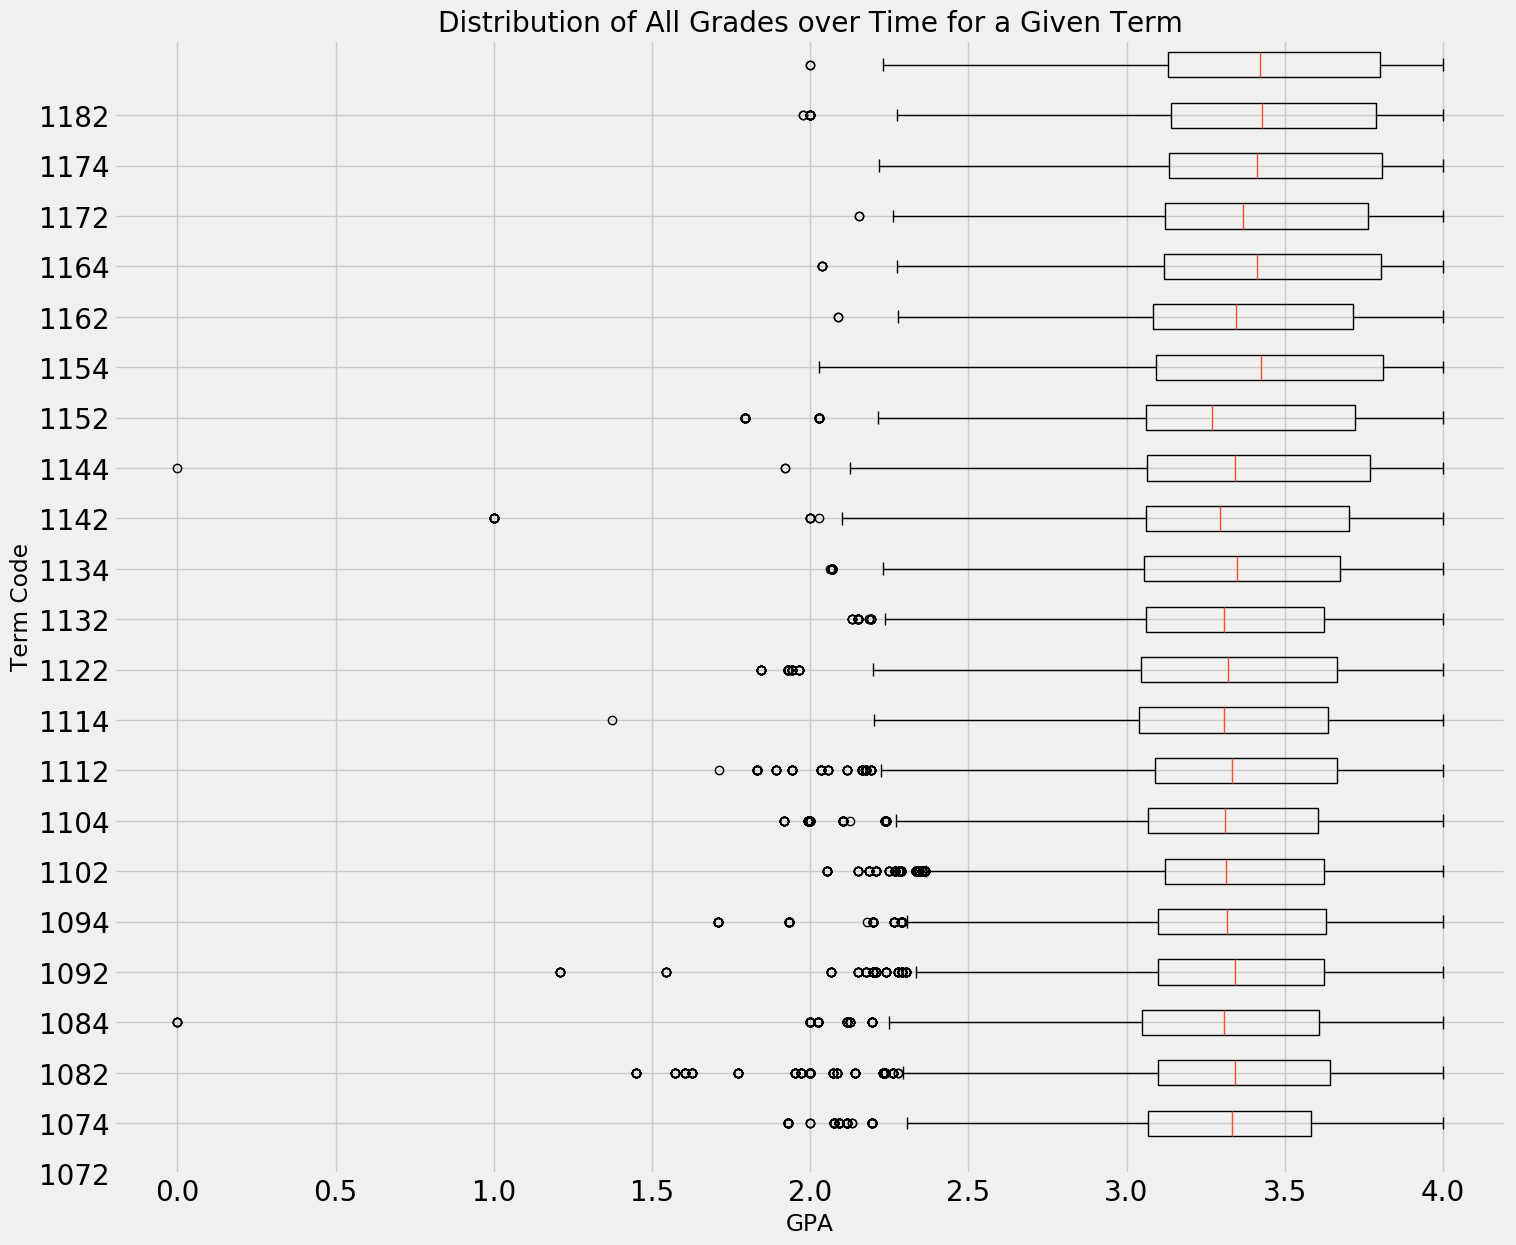

In [40]:
plt.figure(figsize=(16,14))
terms = []
boxes=[]
for i, hour_gpas in enumerate(terms_gdf):
    terms.append(hour_gpas[0])
    boxes.append(hour_gpas[1]["gpa"])
plt.title("Distribution of All Grades over Time for a Given Term")
plt.ylabel("Term Code")
plt.xlabel("GPA")
plt.boxplot(boxes, vert=0)
plt.yticks(range(len(terms)), terms)
plt.show()
plt.close()

Resampling the population just as before

In [41]:
gpa_term_means = terms_gdf["gpa"].apply(lambda x: x.mean())
gpa_term_samples_means = []
for i in range(100):
    gtsm = terms_gdf.obj.sample(int(terms_gdf.obj.shape[0] * 1), replace=True)
    id
    gtsm = gtsm.groupby("term_code")["gpa"].apply(lambda x: x.mean())
    gpa_term_samples_means.append(gtsm)

It can be seen that most recently the average GPA has increased.  There is also very little variance in the random sampling of our data.

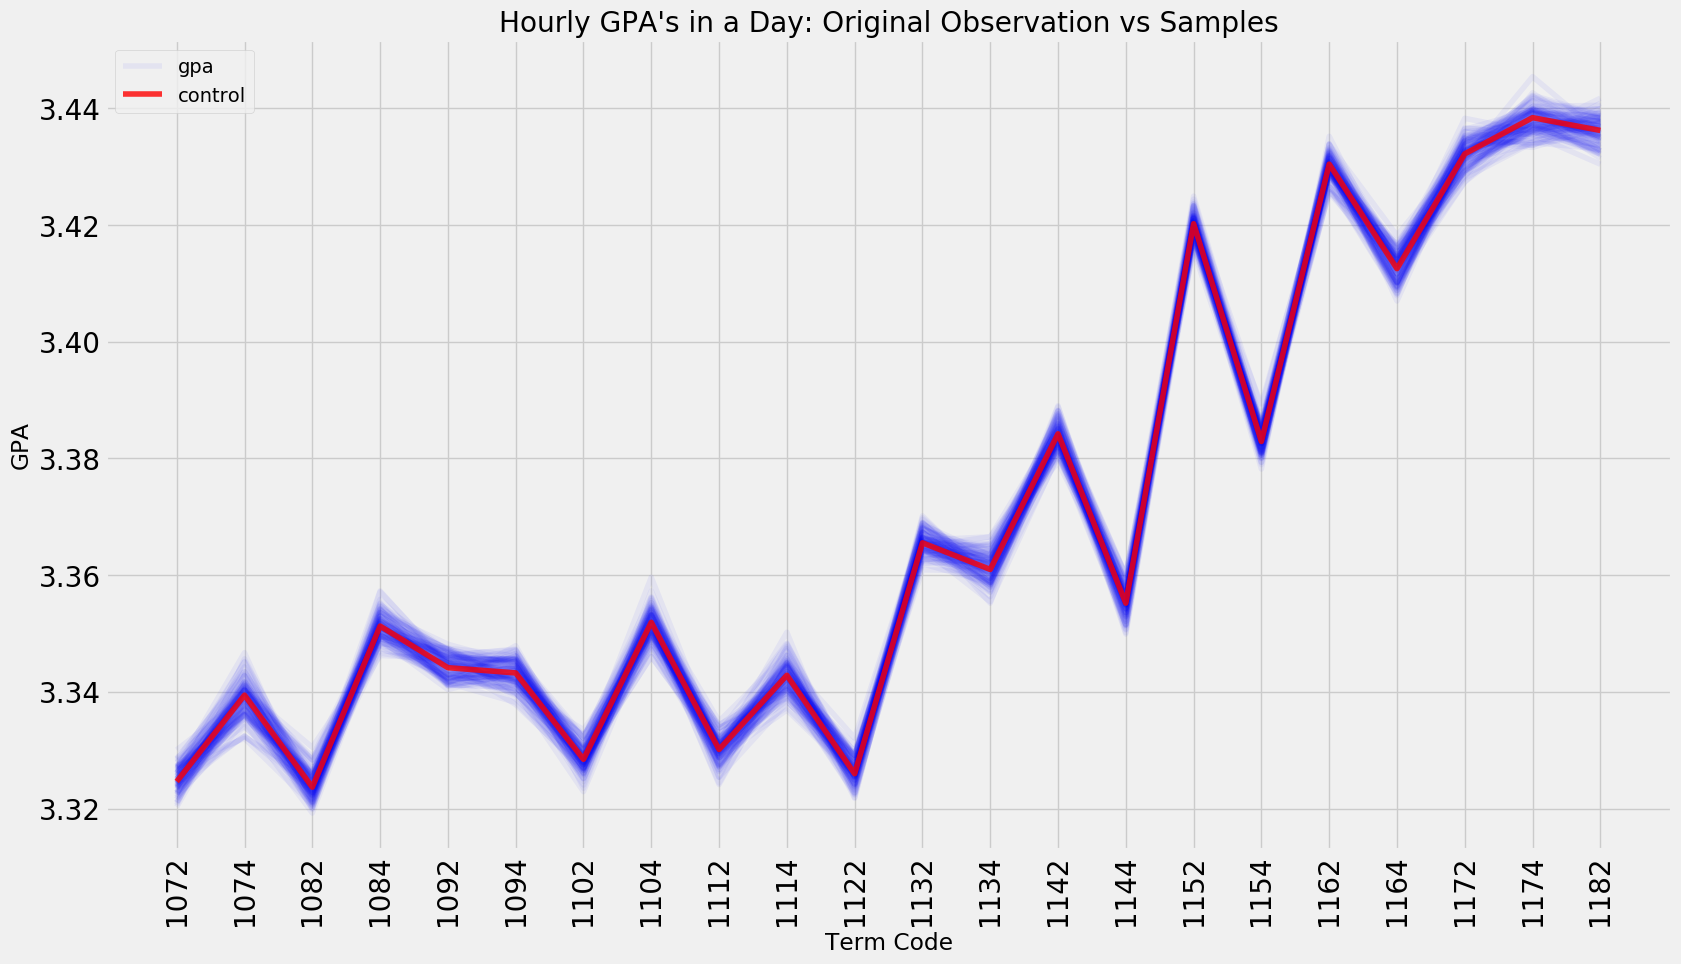

In [43]:
plt.figure(figsize=(18,10))

for i, gwhsm in enumerate(gpa_term_samples_means):
    if i == 0:
        plt.plot(gwhsm, alpha=0.05, color="blue")
        continue
    plt.plot(gwhsm, alpha=0.05, color="blue", label="")

plt.xlabel("Term Code")
plt.xticks(rotation=90)
plt.ylabel("GPA")
plt.plot(gpa_term_means, alpha=0.8, label="control", color="red")
plt.title("Hourly GPA's in a Day: Original Observation vs Samples")
plt.legend(loc="upper left")
plt.show()